In [32]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report 
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

In [30]:
spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.config("spark.driver.memory", "8g")\
.config("spark.driver.cores", "4")\
.getOrCreate()

In [33]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

c:\Users\KourtniConnor\anaconda3\lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [35]:
import os
os.getcwd()

'c:\\Users\\KourtniConnor\\Documents\\Fall23\\BAN\\smallproject2'

In [38]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


In [39]:
df.show(4)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [40]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



# handle 999 in pdays column

In [42]:
from pyspark.sql.functions import col, when

# Create a column to indicate pdays missing
df = df.withColumn('pdays_missing', when(col('pdays') == 999, 1).otherwise(0))

# Replace 999 with mean
mean_pdays = df.filter(col('pdays') != 999).agg({'pdays': 'mean'}).collect()[0][0]
df = df.withColumn('pdays', when(col('pdays') == 999, mean_pdays).otherwise(col('pdays')))

# EDA

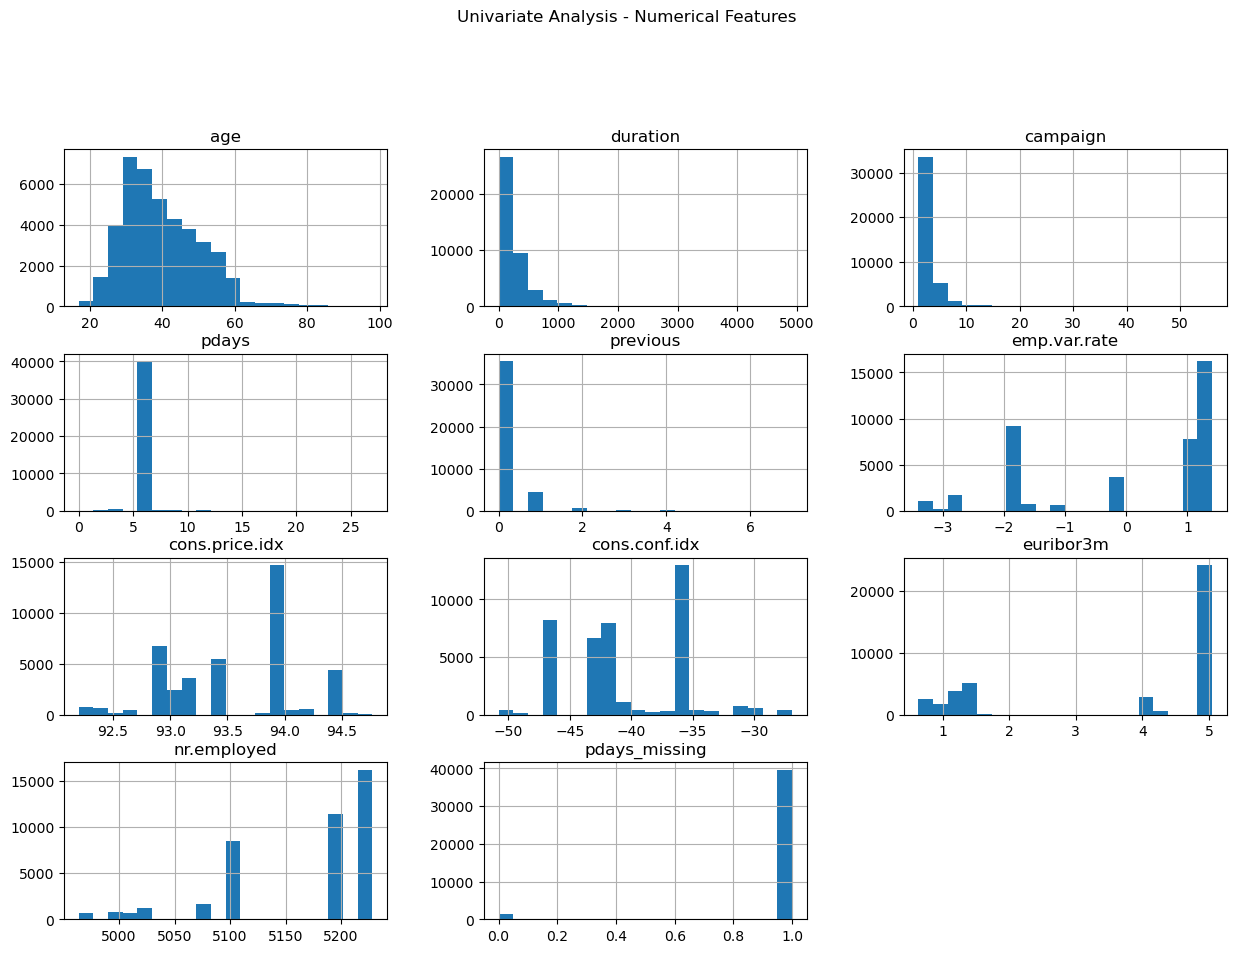

In [55]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
df_pd = df.toPandas()

# Univariate analysis: Distribution of numerical features
numerical_features = df_pd.select_dtypes(include=['float64', 'int32'])
numerical_features.hist(bins=20, figsize=(15, 10))
plt.suptitle('Univariate Analysis - Numerical Features', y=1.02)
plt.show()

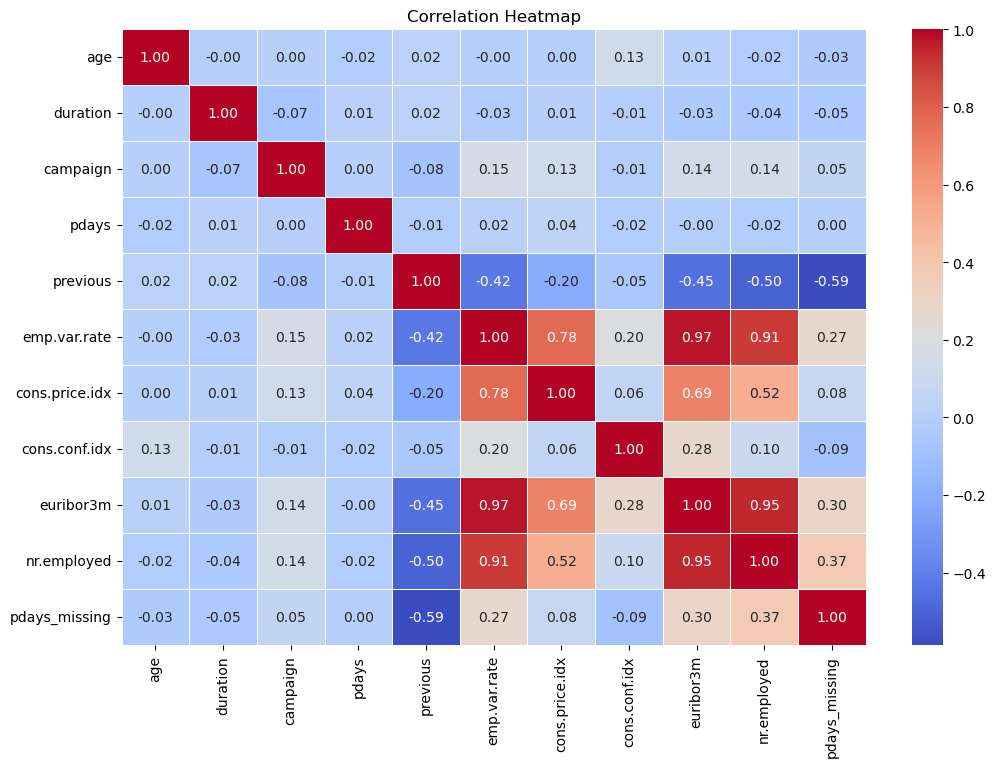

In [56]:
# Correlation heatmap for numerical features
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# Drop Columns to avoid multicollinearity

In [58]:
# Assuming 'column1' and 'column2' are the names of the columns you want to drop
columns_to_drop = ['nr.employed', 'emp.var.rate']
df_pd.drop(columns=columns_to_drop, axis=1, inplace=True)


In [59]:
# Define the bin edges and labels
bin_edges = [0, 25, 35, 45, 55, 65, 100] 
bin_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66+']

# Create a new column 'age_group' based on the age bins
df_pd['age_group'] = pd.cut(df_pd['age'], bins=bin_edges, labels=bin_labels, right=False)

# drop age
df_pd.drop(columns='age', axis=1, inplace=True)

# Normalize integers with wide range

In [60]:
numerical_features = df_pd[['duration']]

# Standardization
standard_scaler = StandardScaler()
normalized_features = pd.DataFrame(standard_scaler.fit_transform(numerical_features), columns=numerical_features.columns)

# dummy encode 

In [73]:
# Assuming df is your DataFrame
df_encoded = pd.get_dummies(df_pd, columns=['age_group','job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'], drop_first=True)


# Split into train/test

In [74]:
# Extract features and target variable
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

In [75]:
# split into 70:30 ration 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) 

# LR before smote

In [76]:

# logistic regression object 
lr = LogisticRegression(max_iter=1500) 
  
# train the model on train set 
lr.fit(X_train, y_train.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

          no       0.93      0.97      0.95     10969
         yes       0.66      0.43      0.52      1388

    accuracy                           0.91     12357
   macro avg       0.80      0.70      0.73     12357
weighted avg       0.90      0.91      0.90     12357



# Smote for imbalanced target variable

In [65]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# LR After SMOTE

In [66]:
lr1 = LogisticRegression(max_iter=1500) 
lr1.fit(X_train_resampled, y_train_resampled.ravel()) 
predictions = lr1.predict(X_test) 

# print classification report 
print(classification_report(y_test, predictions)) 


              precision    recall  f1-score   support

          no       0.94      0.95      0.95     10969
         yes       0.58      0.50      0.54      1388

    accuracy                           0.90     12357
   macro avg       0.76      0.73      0.74     12357
weighted avg       0.90      0.90      0.90     12357



# Random Forrest for variable importance

Feature Importances:
                          Feature    Importance
0                        duration  2.915898e-01
6                       euribor3m  1.238738e-01
1                        campaign  4.536239e-02
5                   cons.conf.idx  3.957960e-02
4                  cons.price.idx  3.558590e-02
7                   pdays_missing  3.461711e-02
2                           pdays  2.385844e-02
37                    housing_yes  2.194065e-02
55               poutcome_success  2.000208e-02
39                       loan_yes  1.449418e-02
24                marital_married  1.427613e-02
8                 age_group_26-35  1.409201e-02
3                        previous  1.384943e-02
32    education_university.degree  1.380278e-02
51                day_of_week_thu  1.339118e-02
50                day_of_week_mon  1.329881e-02
52                day_of_week_tue  1.317912e-02
53                day_of_week_wed  1.301717e-02
29          education_high.school  1.296978e-02
9                 a

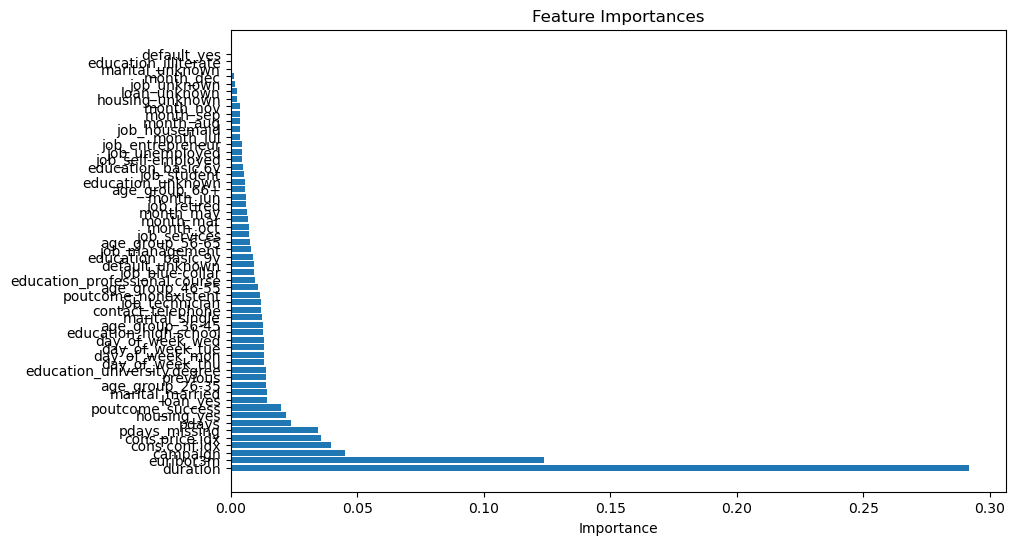

In [77]:
# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [78]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9141


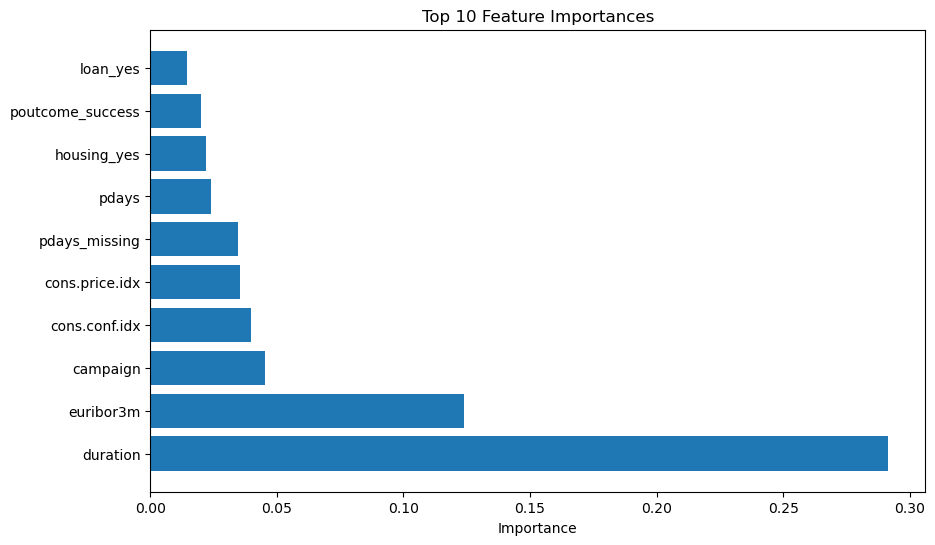

In [79]:
# Sort the DataFrame by Importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_10_features = feature_importance_df.head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.show()

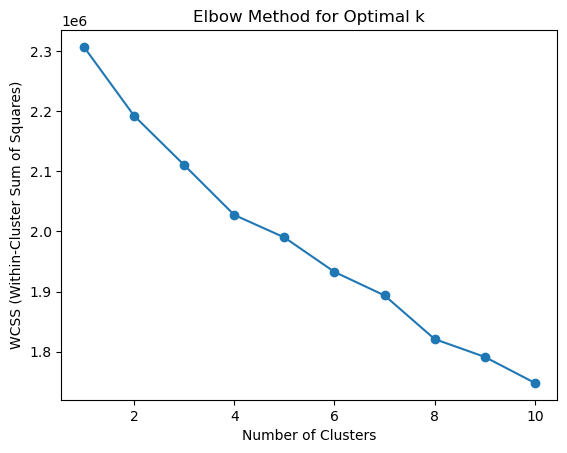

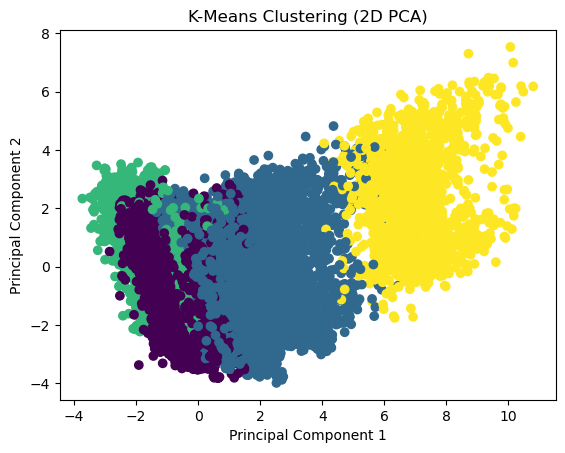

In [80]:
# Standardize the feature matrix (optional but often recommended for k-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for visualization (optional, for 2D plotting)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Determine the optimal number of clusters using the elbow method
wcss = []  # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Based on the elbow method, choose the optimal number of clusters
optimal_k = 4  # Adjust based on the plot

# Apply k-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_scaled)

# Add the cluster labels to the original dataset
cluster_labels = kmeans.labels_
df_clustered = pd.DataFrame(data=X, columns=df_encoded)
df_clustered['Cluster'] = cluster_labels

# Visualize the clusters in 2D (using the first two principal components)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-Means Clustering (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()